In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
import ROOT
import uproot
import os
import sys

%jsroot on
%matplotlib qt

Welcome to JupyROOT 6.28/04


In [4]:
os.environ['PATH'] = '/Library/TeX/texbin:' + os.environ['PATH']
mpl.rc('font', **{'family':'serif', 'serif':['Computer Modern Roman']})
params = {'backend': 'pdf',
          'axes.labelsize': 20,
          'font.size': 20,
          'legend.fontsize': 20,
          'xtick.labelsize': 20,
          'ytick.labelsize': 20,
          'text.usetex': True,
          'figure.figsize': (5,5),
          'axes.unicode_minus': True}
mpl.rcParams.update(params)

In [5]:
refractiveIndices = [
    (2.32542 ,1.84214),
    (1.97009 ,1.85093),
    (1.52958 ,1.86146),
    (1.12864 ,1.87327),
    (1.01398 ,1.87807),
    (0.85211 ,1.88758),
    (0.76819 ,1.89479),
    (0.70652 ,1.90181),
    (0.65627 ,1.90916),
    (0.64385 ,1.91127),
    (0.63280 ,1.91327),
    (0.58929 ,1.92245),
    (0.58756 ,1.92286),
    (0.54607 ,1.93429),
    (0.48613 ,1.95800),
    (0.47999 ,1.96112),
    (0.44157 ,1.98526),
    (0.435835,1.98972),
    (0.404656,2.01976)
]
refractiveIndices = np.array(refractiveIndices)

# Convert wavelengths from air to liquid xenon
refractiveIndices[:, 0] /= 1.69

# Convert wavelengths from um to nm
refractiveIndices[:, 0] *= 1000

In [12]:
import scipy.optimize as opt

def func(x, a, b, c, d):
    return a * 1/x + b * x + c * x**2 + d

def fit_data(x, y):
    # Define the function to fit the data
    # def func(x, a, b, c):
    #     return a * 1/x + b * x + c
    # def func(x, a, b):
    #     return a * 1/x + b

    # Perform the fit with more points
    x_fit = np.linspace(150, max(x), 100)
    params, _ = opt.curve_fit(func, x, y)
    y_fit = func(x_fit, *params)

    print('refInd(185nm) =', func(185, *params))

    return params, x_fit, y_fit

params, x_fit, y_fit = fit_data(refractiveIndices[:,0], refractiveIndices[:,1])
fig_fit, ax_fit = plt.subplots(figsize=(10, 6))
ax_fit.plot(refractiveIndices[:,0], refractiveIndices[:,1], 'o', label='data')
ax_fit.plot(x_fit, y_fit, '-', label='fit')
ax_fit.axvline(x=185, color='gray', linestyle='-.')
ax_fit.axhline(y=func(185, *params), color='gray', linestyle='-.')
ax_fit.plot(185, func(185, *params), 'ro', label='$n_{185}$')
ax_fit.set_xlabel('Wavelength [nm]')
ax_fit.set_ylabel('Index of Refraction ($n$)')
ax_fit.set_title('S-NPH2')
ax_fit.grid(True)
ax_fit.legend()
plt.show()

print('Parameters:', params)

refInd(185nm) = 2.102809942396481
Parameters: [ 8.84663463e+01  3.67776321e-04 -1.55087042e-07  1.56188271e+00]


In [15]:
file_input_name = '../runs/calibration_4_photonCreator.root'
# file_input_name = '../runs/output_2.root'
# file_input_name = '../build/calibration_0_0_0.root'
histogram_directory = 'photoSensor_hits_histograms'
file_input_pyroot = ROOT.TFile(file_input_name)
file_input_uproot = uproot.open(file_input_name)

histogram_names = file_input_uproot.keys()
histogram_names = [name for name in histogram_names if histogram_directory + '/photoSensor_' in name]
tree_names = file_input_uproot.keys()
tree_names = [name for name in tree_names if histogram_directory not in name]

print(histogram_names)
print(tree_names)

[]
['photoSensor_hits;2', 'photoSensor_hits;1', 'photoSensor_hits/photoSensor_0;1', 'photoSensor_hits/photoSensor_1;1', 'photoSensor_hits/photoSensor_2;1', 'photoSensor_hits/photoSensor_3;1', 'photoSensor_hits/photoSensor_4;1', 'photoSensor_hits/photoSensor_5;1', 'photoSensor_hits/photoSensor_6;1', 'photoSensor_hits/photoSensor_7;1', 'photoSensor_hits/photoSensor_8;1', 'photoSensor_hits/photoSensor_9;1', 'photoSensor_hits/photoSensor_10;1', 'photoSensor_hits/photoSensor_11;1', 'photoSensor_hits/photoSensor_12;1', 'photoSensor_hits/photoSensor_13;1', 'photoSensor_hits/photoSensor_14;1', 'photoSensor_hits/photoSensor_15;1', 'photoSensor_hits/photoSensor_16;1', 'photoSensor_hits/photoSensor_17;1', 'photoSensor_hits/photoSensor_18;1', 'photoSensor_hits/photoSensor_19;1', 'photoSensor_hits/photoSensor_20;1', 'photoSensor_hits/photoSensor_21;1', 'photoSensor_hits/photoSensor_22;1', 'photoSensor_hits/photoSensor_23;1', 'photoSensor_hits/photoSensor_24;1', 'photoSensor_hits/photoSensor_25;1', 

In [14]:
hits_list_library = {}
hits_hist_library = {}
for name in histogram_names:
    # Get the histogram from the ROOT file
    histogram = file_input_pyroot.Get(name)

    # Get the number of bins in the X and Y directions
    n_bins_x = histogram.GetNbinsX()
    n_bins_y = histogram.GetNbinsY()

    # Create NumPy arrays to store the bin contents and edges
    values = np.zeros((n_bins_x, n_bins_y))
    hits = []
    x_edges = []
    y_edges = []

    # Extract the bin contents (values) and edges
    for i in range(1, n_bins_x + 2):
        x_edges.append(histogram.GetXaxis().GetBinLowEdge(i))
    for i in range(1, n_bins_y + 2):
        y_edges.append(histogram.GetYaxis().GetBinLowEdge(i))

    for i in range(n_bins_x):  # Change the range to avoid going out of bounds
        for j in range(n_bins_y):  # Change the range to avoid going out of bounds
            values[i][j] = histogram.GetBinContent(j + 1, i + 1)
            if histogram.GetBinContent(j + 1, i + 1) > 0:
                # Check if edges are within bounds before accessing
                if j < len(y_edges) - 1 and i < len(x_edges) - 1:
                    hits.append(
                        (y_edges[j] + (y_edges[j + 1] - y_edges[j]) / 2, x_edges[i] + (x_edges[i + 1] - x_edges[i]) / 2)
                    )

    print(name,hits)
    hits_list_library[name] = hits
    hits_hist_library[name] = values

In [10]:
# Find the entry in hits_library with the largest length
# make a list of the index and length
lengths = [(i, len(hits)) for i, hits in enumerate(hits_list_library.values())]
lengths.sort(key=lambda x: x[1])

plt.hist([lengths[i][1] for i in range(len(lengths))], bins=12)
plt.xlabel("Number of hits")
plt.ylabel("")
plt.title("Number of hits per detector")
plt.grid()
plt.show()

In [11]:
index, length = lengths[-1]
hits = list(hits_list_library.values())[index]
values = list(hits_hist_library.values())[index]

plt.imshow(values, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), aspect='auto', origin='lower', cmap='viridis')
plt.plot([x[0] for x in hits], [x[1] for x in hits], 'o', alpha=0.1, color='red')
plt.colorbar()
plt.xlabel("x distance [mm]")
plt.ylabel("y distance [mm]")
plt.title("Most hit detector")
plt.grid()
plt.show()

IndexError: list index out of range

In [ ]:
# Load the trees from the root file
tree_library = {}
tree_branch_library = {}
branch_data = {}
for name in tree_names:
    tree_library[name] = file_input_uproot[name]
    tree_branch_library[name] = tree_library[name].keys()
    for key in tree_branch_library[name]:
        branch_data[key] = tree_library[name][key].array()

In [ ]:
# %matplotlib qt

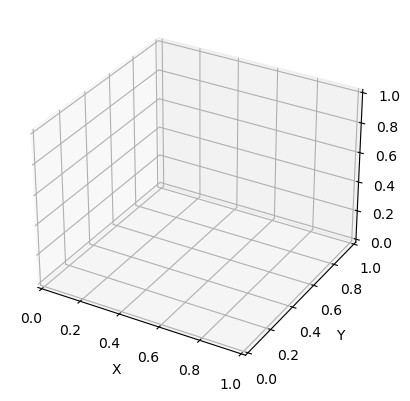

In [ ]:
primary_position_x  = np.array(branch_data['primary_position_x'])
primary_position_y  = np.array(branch_data['primary_position_y'])
primary_position_z  = np.array(branch_data['primary_position_z'])
primary_direction_x = np.array(branch_data['primary_direction_x'])
primary_direction_y = np.array(branch_data['primary_direction_y'])
primary_direction_z = np.array(branch_data['primary_direction_z'])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.quiver(primary_position_x , primary_position_y , primary_position_z , 
          primary_direction_x, primary_direction_y, primary_direction_z, 
          length=0.1, color='red')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

In [ ]:
%matplotlib inline

In [ ]:
# Extract the data for photon_process and photon_volume
photon_process = branch_data['photon_process']
photon_volume = branch_data['photon_volume']

# Make a list of the unique photon_process and photon_volume values
unique_photon_process = np.unique(photon_process)
unique_photon_volume = np.unique(photon_volume)

# Make a dictionary to store the number of photons in each process and volume
photon_process_count = {}
photon_volume_count = {}

# Loop over the unique photon_process values
for process in unique_photon_process:
    # Get the indices for the current process
    indices = np.where(photon_process == process)
    # Store the number of photons in the current process
    photon_process_count[process] = len(indices[0])

# Loop over the unique photon_volume values
for volume in unique_photon_volume:
    # Get the indices for the current volume
    indices = np.where(photon_volume == volume)
    # Store the number of photons in the current volume
    photon_volume_count[volume] = len(indices[0])

# Print the photon_process_count and photon_volume_count dictionaries
print(photon_process_count)
print(photon_volume_count)

# Combine individualy named volumes into more general volumes
photon_volume_general_count = {}
for volume in photon_volume_count:
    if 'lensSystem_solid' in volume:
        photon_volume_general_count['lensSystem_solid'] = photon_volume_general_count.get('lensSystem_solid', 0) + photon_volume_count[volume]
    elif 'photoSensor_surface' in volume:
        photon_volume_general_count['photoSensor_surface'] = photon_volume_general_count.get('photoSensor_surface', 0) + photon_volume_count[volume]
    elif 'photoSensor_body' in volume:
        photon_volume_general_count['phototSensor_body'] = photon_volume_general_count.get('phototSensor_body', 0) + photon_volume_count[volume]
    elif 'calorimeter_horizontal' in volume:
        photon_volume_general_count['calorimeter_horizontal'] = photon_volume_general_count.get('calorimeter_horizontal', 0) + photon_volume_count[volume]
    elif 'calorimeter_vertical' in volume:
        photon_volume_general_count['calorimeter_vertical'] = photon_volume_general_count.get('calorimeter_vertical', 0) + photon_volume_count[volume]
    elif 'calorimeter_middle' in volume:
        photon_volume_general_count['calorimeter_middle'] = photon_volume_general_count.get('calorimeter_middle', 0) + photon_volume_count[volume]
    else:
        photon_volume_general_count[volume] = photon_volume_general_count.get(volume, 0) + photon_volume_count[volume]

# Print the photon_volume_general_count dictionary
print(photon_volume_general_count)

{'OpAbsorption': 893590, 'OpRayleigh': 1875, 'Transportation': 307174}
{'/DSPD_+x_0_lensSystem_solid': 15, '/DSPD_+x_10_lensSystem_solid': 22, '/DSPD_+x_11_lensSystem_solid': 37, '/DSPD_+x_12_lensSystem_solid': 67, '/DSPD_+x_13_lensSystem_solid': 88, '/DSPD_+x_13_photoSensor_body': 1, '/DSPD_+x_13_photoSensor_surface': 1, '/DSPD_+x_14_lensSystem_solid': 158, '/DSPD_+x_15_lensSystem_solid': 114, '/DSPD_+x_16_lensSystem_solid': 114, '/DSPD_+x_16_photoSensor_surface': 1, '/DSPD_+x_17_lensSystem_solid': 90, '/DSPD_+x_18_lensSystem_solid': 32, '/DSPD_+x_19_lensSystem_solid': 20, '/DSPD_+x_1_lensSystem_solid': 29, '/DSPD_+x_20_lensSystem_solid': 46, '/DSPD_+x_21_lensSystem_solid': 72, '/DSPD_+x_21_photoSensor_body': 1, '/DSPD_+x_22_lensSystem_solid': 104, '/DSPD_+x_22_photoSensor_body': 15, '/DSPD_+x_22_photoSensor_surface': 15, '/DSPD_+x_23_lensSystem_solid': 190, '/DSPD_+x_23_photoSensor_body': 25, '/DSPD_+x_23_photoSensor_surface': 30, '/DSPD_+x_24_lensSystem_solid': 287, '/DSPD_+x_24_pho

[83411, 15866, 16352, 45235, 3545, 45151, 964464, 14159, 14456]
[893590, 1875, 307174]


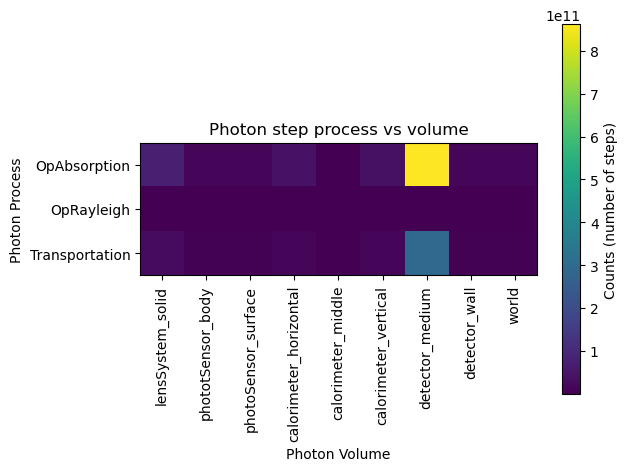

In [ ]:
photon_volume_general_count_values = list(photon_volume_general_count.values())
photon_process_count_values = list(photon_process_count.values())

print(photon_volume_general_count_values)
print(photon_process_count_values)

convolution_matrix = np.outer(photon_process_count_values, photon_volume_general_count_values)
plt.imshow(convolution_matrix, cmap='viridis')
plt.xlabel("Photon Volume")
plt.ylabel("Photon Process")
plt.title("Photon step process vs volume")
plt.yticks(range(len(photon_process_count)), photon_process_count.keys())
plt.xticks(range(len(photon_volume_general_count)), photon_volume_general_count.keys())
plt.xticks(rotation=90)
plt.colorbar(label='Counts (number of steps)')
plt.show()